# Pleas read:

before your start running this jupyter notebook, please click Edit > Notebook Settings and choose any of the available GPUs.

## 0. Import Python Packages

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## 1. Define ResNet18

In [8]:
class Block(nn.Module):
    """This is courtesy of GeeksForGeeks for the initial implementation."""
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    """This is courtesy of GeeksForGeeks for the initial implementation."""
    def __init__(self, num_classes=10, in_channels=3):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.l1 = self._make_layer(Block, 64, 2, stride=1)
        self.l2 = self._make_layer(Block, 128, 2, stride=2)
        self.l3 = self._make_layer(Block, 256, 2, stride=2)
        self.l4 = self._make_layer(Block, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.l1(out)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## 2. Implement training loop and test function

In [9]:
def train(model, device, train_loader, optimizer, epoch, scheduler):
    losses = []
    model.train()
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(X)
        loss = F.nll_loss(F.log_softmax(y_hat, dim=1), y.long())
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            losses.append(loss.item())
    scheduler.step()
    return losses

def test(model, device, test_loader):
    model.eval()
    loss = 0
    accuracy = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss += F.nll_loss(F.log_softmax(output, dim=1), y.long(), reduction='sum').item()
            predicted = F.log_softmax(output, dim=1).argmax(dim=1, keepdim=True)
            accuracy += predicted.eq(y.view_as(predicted)).sum().item()

    loss /= len(test_loader.dataset)
    accuracy /= len(test_loader.dataset)

    return loss, accuracy

In [25]:
def run(
    epochs: int,
    device: torch.device,
    train_dl: torch.utils.data.DataLoader,
    val_dl: torch.utils.data.DataLoader,
    test_dl: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.StepLR,
):
    train_losses = []
    val_losses = []
    best = float('inf')
    patience = 5
    stop = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        loss = train(model, device, train_dl, optimizer, epoch, scheduler)
        train_losses.append(sum(loss) / len(loss))
        val_loss, _ = test(model, device, val_dl)
        val_losses.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}")
        if val_loss < best:
            best = val_loss
            stop = 0
        else:
            stop += 1
        if stop >= patience:
            print("Early stopping triggered.")
            break
    test_loss, test_accuracy = test(model, device, test_dl)
    return train_losses, val_losses, test_loss, test_accuracy

## 3. MNIST


In [26]:
MNIST_TRAIN = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
MNIST_TEST = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

train_size = int(0.8 * len(MNIST_TRAIN))
val_size = len(MNIST_TRAIN) - train_size

MNIST_TRAIN, MNIST_VALIDATION = torch.utils.data.random_split(MNIST_TRAIN, [train_size, val_size])

In [27]:
batch = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dl = torch.utils.data.DataLoader(MNIST_TRAIN, batch_size=batch, shuffle=True)
val_dl = torch.utils.data.DataLoader(MNIST_VALIDATION, batch_size=batch, shuffle=True)
test_dl = torch.utils.data.DataLoader(MNIST_TEST, batch_size=batch, shuffle=True)

In [28]:
def search__mnist():
    EPOCHS = 15
    LRS = [5e-2, 1e-2, 5e-3]
    OPTIMIZERS = [
        ("SGD", lambda params, lr: torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=1e-4)),
        ("Adam", lambda params, lr: torch.optim.Adam(params, lr=lr, weight_decay=1e-4)),
        ("Adagrad", lambda params, lr: torch.optim.Adagrad(params, lr=lr, weight_decay=1e-4)),
    ]
    results = []
    for opt_name, opt_fn in OPTIMIZERS:
        for lr in LRS:
            print(f"\n=== {opt_name} | lr={lr} ===")
            model = ResNet18(in_channels=1).to(device)
            optimizer = opt_fn(model.parameters(), lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=EPOCHS // 3, gamma=0.5)
            _, val_losses, test_loss, test_accuracy = run(
                epochs=EPOCHS,
                device=device,
                train_dl=train_dl,
                val_dl=val_dl,
                test_dl=test_dl,
                model=model,
                optimizer=optimizer,
                scheduler=scheduler,
            )
            result = {
                "optimizer": opt_name,
                "lr": lr,
                "val_loss": val_losses[-1] if len(val_losses) > 0 else float("inf"),
                "test_loss": test_loss,
                "test_accuracy": test_accuracy,
            }
            results.append(result)
            print(f"Final: val_loss={result['val_loss']:.4f}, test_acc={test_accuracy:.4f}")
    best = min(results, key=lambda r: r["val_loss"]) if len(results) > 0 else None
    if best is not None:
        print(f"\nBest by val_loss: {best}")
    return results

In [29]:
results = search__mnist()


=== SGD | lr=0.05 ===
Epoch 1/15
Validation Loss: 0.0516
Epoch 2/15
Validation Loss: 0.0408
Epoch 3/15
Validation Loss: 0.0461
Epoch 4/15
Validation Loss: 0.0395
Epoch 5/15
Validation Loss: 0.0327
Epoch 6/15
Validation Loss: 0.0210
Epoch 7/15
Validation Loss: 0.0231
Epoch 8/15
Validation Loss: 0.0194
Epoch 9/15
Validation Loss: 0.0245
Epoch 10/15
Validation Loss: 0.0208
Epoch 11/15
Validation Loss: 0.0208
Epoch 12/15
Validation Loss: 0.0212
Epoch 13/15
Validation Loss: 0.0200
Early stopping triggered.
Final: val_loss=0.0200, test_acc=0.9945

=== SGD | lr=0.01 ===
Epoch 1/15
Validation Loss: 0.0469
Epoch 2/15
Validation Loss: 0.0390
Epoch 3/15
Validation Loss: 0.0297
Epoch 4/15
Validation Loss: 0.0329
Epoch 5/15
Validation Loss: 0.0427
Epoch 6/15
Validation Loss: 0.0178
Epoch 7/15
Validation Loss: 0.0177
Epoch 8/15
Validation Loss: 0.0192
Epoch 9/15
Validation Loss: 0.0182
Epoch 10/15
Validation Loss: 0.0174
Epoch 11/15
Validation Loss: 0.0171
Epoch 12/15
Validation Loss: 0.0174
Epoch 

In [ ]:
# Code courtesy of ChatGPT

lr_order = sorted({r["lr"] for r in results})
opt_order = sorted({r["optimizer"] for r in results})

print("All results (sorted by optimizer, lr):")
print(f"{'optimizer':<12} {'lr':>10} {'val_loss':>10} {'test_acc':>10} {'test_loss':>10}")
for opt in opt_order:
    for lr in lr_order:
        r = next((x for x in results if x['optimizer'] == opt and x['lr'] == lr), None)
        if r is None:
            continue
        print(f"{opt:<12} {lr:>10.5f} {r['val_loss']:>10.4f} {r['test_accuracy']:>10.4f} {r['test_loss']:>10.4f}")

def print_metric_grid(metric_key, title):
    print(f"\n{title}")
    header = ["optimizer\\lr"] + [f"{lr:>10.5f}" for lr in lr_order]
    print(" ".join(header))
    for opt in opt_order:
        row = [f"{opt:<12}"]
        for lr in lr_order:
            r = next((x for x in results if x['optimizer'] == opt and x['lr'] == lr), None)
            if r is None or metric_key not in r:
                row.append(f"{'NA':>10}")
            else:
                row.append(f"{r[metric_key]:>10.4f}")
        print(" ".join(row))

print_metric_grid("val_loss", "Validation loss grid (lower is better):")
print_metric_grid("test_accuracy", "Test accuracy grid (higher is better):")

All results (sorted by optimizer, lr):
optimizer            lr   val_loss   test_acc  test_loss
Adagrad         0.00500     0.0215     0.9941     0.0233
Adagrad         0.01000     0.0211     0.9939     0.0226
Adagrad         0.05000     0.0251     0.9929     0.0279
Adam            0.00500     0.0315     0.9904     0.0328
Adam            0.01000     0.0322     0.9924     0.0257
Adam            0.05000     0.1068     0.9699     0.1011
SGD             0.00500     0.0191     0.9948     0.0185
SGD             0.01000     0.0174     0.9951     0.0164
SGD             0.05000     0.0200     0.9945     0.0186

Validation loss grid (lower is better):
optimizer\lr    0.00500    0.01000    0.05000
Adagrad          0.0215     0.0211     0.0251
Adam             0.0315     0.0322     0.1068
SGD              0.0191     0.0174     0.0200

Test accuracy grid (higher is better):
optimizer\lr    0.00500    0.01000    0.05000
Adagrad          0.9941     0.9939     0.9929
Adam             0.9904     0.9924

In [33]:
mnist_epochs = 15
model = ResNet18(in_channels=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=mnist_epochs // 3, gamma=0.5)

train_losses, val_losses, test_loss, test_accuracy = run(mnist_epochs, device, train_dl, val_dl, test_dl, model, optimizer, scheduler)

Epoch 1/15
Validation Loss: 0.0447
Epoch 2/15
Validation Loss: 0.0400
Epoch 3/15
Validation Loss: 0.0289
Epoch 4/15
Validation Loss: 0.0264
Epoch 5/15
Validation Loss: 0.0276
Epoch 6/15
Validation Loss: 0.0194
Epoch 7/15
Validation Loss: 0.0184
Epoch 8/15
Validation Loss: 0.0198
Epoch 9/15
Validation Loss: 0.0180
Epoch 10/15
Validation Loss: 0.0183
Epoch 11/15
Validation Loss: 0.0180
Epoch 12/15
Validation Loss: 0.0179
Epoch 13/15
Validation Loss: 0.0179
Epoch 14/15
Validation Loss: 0.0179
Epoch 15/15
Validation Loss: 0.0181


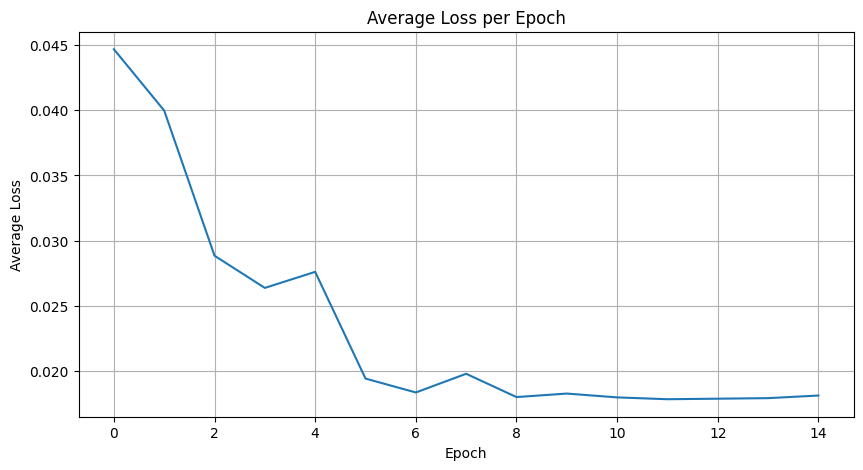

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss per Epoch")
plt.grid(True)
plt.show()

In [35]:
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.9961


# CIFAR10

In [ ]:
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.5, 1.5), shear=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),    
    transforms.ToTensor(),
])
CIFAR10_TRAIN = datasets.CIFAR10("./", train=True, transform=data_augmentation, download=True)
CIFAR10_TEST = datasets.CIFAR10("./", train=False, transform=transforms.ToTensor(), download=True)

In [ ]:
results = search__mnist()

# Optional: show best by test accuracy
if len(results) > 0:
    best_by_acc = max(results, key=lambda r: r["test_accuracy"]) 
    print(f"Best by test_accuracy: {best_by_acc}")
